# CNN + MaxPool
Model was overfitting, even with dropout.

Here, reduce number of convolution filters.

In [24]:
from datetime import datetime
print(datetime.now())

2023-03-21 15:50:51.109189


In [25]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

Found GPU at: /device:GPU:0
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [26]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=20 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC

Python 3.9.16
sklearn 1.2.2


In [27]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_lncRNA_transcripts.csv'

In [28]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [29]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

## Model

In [30]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    cnn2_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool1_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    cnn3_layer = Conv1D(CFILTERS//2, FILTERSIZE)
    cnn4_layer = Conv1D(CFILTERS//2, FILTERSIZE)
    pool2_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    flat_layer = Flatten()
    #dens_layer = Dense(DCELLS,activation='relu')
    #drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(cnn2_layer)
    cnn.add(pool1_layer)
    cnn.add(cnn3_layer)
    cnn.add(cnn4_layer)
    cnn.add(pool2_layer)
    cnn.add(flat_layer)
    #cnn.add(dens_layer)
    #cnn.add(drop_layer)
    cnn.add(output_layer)

    # Logits=False because sigmoid output is a probability in range [0.,1.]; see
    # https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class
    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return cnn

In [31]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-21 15:50:53.070848
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 4997, 4)           1028      
                                                                 
 conv1d_52 (Conv1D)          (None, 4990, 64)          2112      
                                                                 
 conv1d_53 (Conv1D)          (None, 4983, 64)          32832     
                                                                 
 max_pooling1d_26 (MaxPoolin  (None, 1244, 64)         0         
 g1D)                                                            
                                                                 
 conv1d_54 (Conv1D)          (None, 1237, 32)          16416     
                                                                 
 conv1d_55 (Conv1D)          (None, 1230, 32)          8224      
                          

## Training

In [32]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [33]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            if gene_id in self.val_genes:
                self.val_ids.append(allids[t])
                self.val_seq.append(allseq[t])
                self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                self.train_ids.append(allids[t])
                self.train_seq.append(allseq[t])
                self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-03-21 15:50:53.330207
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4369 sequences.
2023-03-21 15:51:01.580580

Training # 1 1
2023-03-21 15:51:01.580712
2023-03-21 15:51:01.580762
Discriminator ZERO -1
Train 1:0 1800:1699 51.44%
Computed class weights: {0: 1.029723366686286, 1: 0.9719444444444445}
Valid 1:0 458:412 52.64%
FIT
2023-03-21 15:51:03.017420


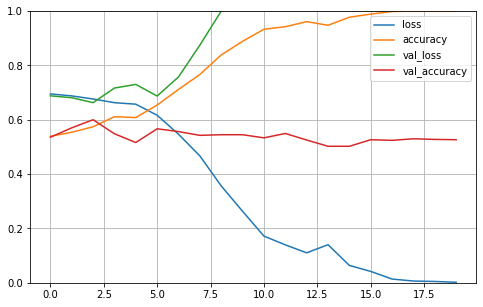


2023-03-21 15:52:01.814979

Testing # 1 1
2023-03-21 15:52:01.816520
2023-03-21 15:52:01.816878
PREDICT
2023-03-21 15:52:02.258825
Test 1:0 458:412 52.64%
Predict 1:0 488:382 56.09%
Test sizes (870, 4997) (870,)
Range of scores: 2.7611913e-13 to 1.0
Score threshold 0.5
Confusion matrix
 [[191 221]
 [191 267]]
Normalized matrix
 [[0.21954023 0.25402299]
 [0.21954023 0.30689655]]


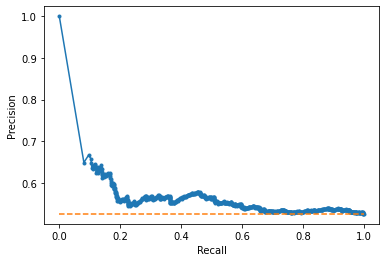

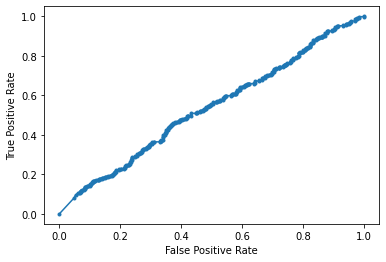

Accuracy: 52.64% Precision: 54.71% Recall: 58.30%
F1: 56.45% MCC: 0.0468
AUPRC: 57.88% AUROC: 53.65%
 accuracy [52.643678160919535]
 precision [54.713114754098356]
 recall [58.29694323144105]
 F1 [56.448202959830866]
 MCC [0.04684554107004169]
 AUPRC [57.87685721277611]
 AUROC [53.64501632255055]
2023-03-21 15:52:03.339390

Training # 1 2
2023-03-21 15:52:03.341083
2023-03-21 15:52:03.344251
Discriminator ZERO -1
Train 1:0 1816:1669 52.11%
Computed class weights: {0: 1.0440383463151588, 1: 0.9595264317180616}
Valid 1:0 442:442 50.00%
FIT
2023-03-21 15:52:05.433614


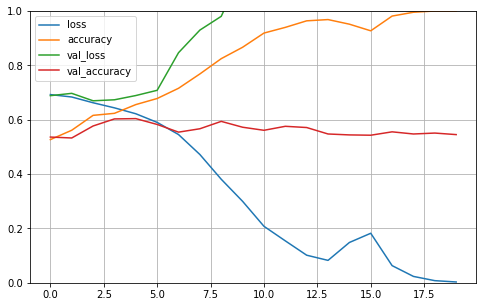


2023-03-21 15:53:03.364161

Testing # 1 2
2023-03-21 15:53:03.364267
2023-03-21 15:53:03.364304
PREDICT
2023-03-21 15:53:03.600922
Test 1:0 442:442 50.00%
Predict 1:0 468:416 52.94%
Test sizes (884, 4997) (884,)
Range of scores: 1.1635433e-23 to 1.0
Score threshold 0.5
Confusion matrix
 [[228 214]
 [188 254]]
Normalized matrix
 [[0.25791855 0.24208145]
 [0.21266968 0.28733032]]


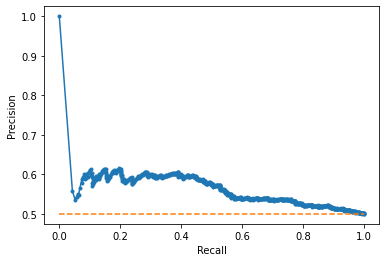

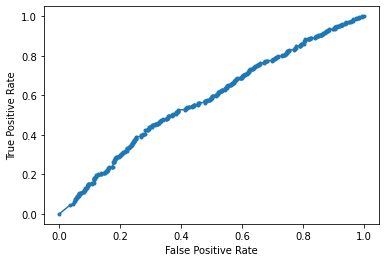

Accuracy: 54.52% Precision: 54.27% Recall: 57.47%
F1: 55.82% MCC: 0.0907
AUPRC: 56.95% AUROC: 57.80%
 accuracy [54.52488687782805]
 precision [54.27350427350427]
 recall [57.466063348416284]
 F1 [55.82417582417582]
 MCC [0.09065471553673686]
 AUPRC [56.9491761131635]
 AUROC [57.79724002375054]
2023-03-21 15:53:04.388650

Training # 1 3
2023-03-21 15:53:04.388792
2023-03-21 15:53:04.388838
Discriminator ZERO -1
Train 1:0 1816:1704 51.59%
Computed class weights: {0: 1.0328638497652582, 1: 0.9691629955947136}
Valid 1:0 442:407 52.06%
FIT
2023-03-21 15:53:05.661448


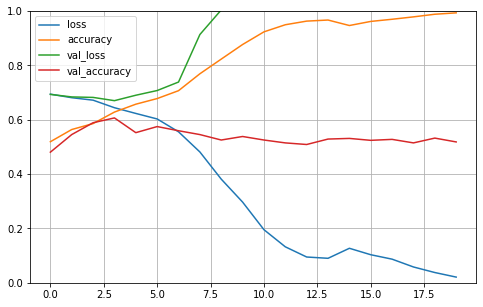


2023-03-21 15:54:02.854697

Testing # 1 3
2023-03-21 15:54:02.856131
2023-03-21 15:54:02.856481
PREDICT
2023-03-21 15:54:03.300482
Test 1:0 442:407 52.06%
Predict 1:0 419:430 49.35%
Test sizes (849, 4997) (849,)
Range of scores: 1.9212738e-15 to 1.0
Score threshold 0.5
Confusion matrix
 [[214 193]
 [216 226]]
Normalized matrix
 [[0.25206125 0.22732627]
 [0.25441696 0.26619552]]


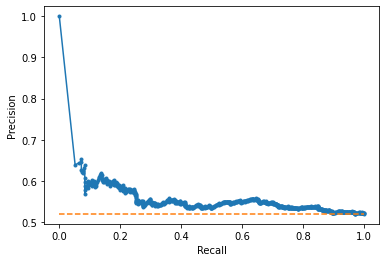

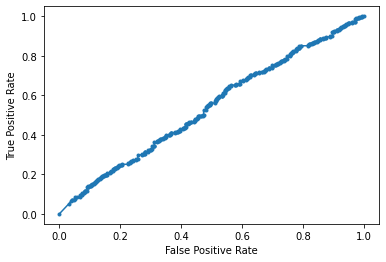

Accuracy: 51.83% Precision: 53.94% Recall: 51.13%
F1: 52.50% MCC: 0.0371
AUPRC: 56.61% AUROC: 53.90%
 accuracy [51.82567726737338]
 precision [53.93794749403341]
 recall [51.13122171945701]
 F1 [52.49709639953542]
 MCC [0.03708230737483154]
 AUPRC [56.61484332599544]
 AUROC [53.90452155158039]
2023-03-21 15:54:04.273463

Training # 1 4
2023-03-21 15:54:04.275253
2023-03-21 15:54:04.275638
Discriminator ZERO -1
Train 1:0 1799:1680 51.71%
Computed class weights: {0: 1.0354166666666667, 1: 0.9669260700389105}
Valid 1:0 459:431 51.57%
FIT
2023-03-21 15:54:06.335899


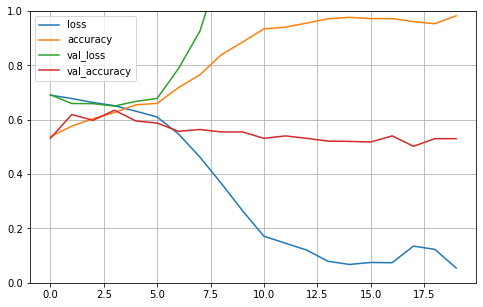


2023-03-21 15:55:29.765259

Testing # 1 4
2023-03-21 15:55:29.765379
2023-03-21 15:55:29.765421
PREDICT
2023-03-21 15:55:29.996440
Test 1:0 459:431 51.57%
Predict 1:0 419:471 47.08%
Test sizes (890, 4997) (890,)
Range of scores: 1.0978863e-24 to 1.0
Score threshold 0.5
Confusion matrix
 [[242 189]
 [229 230]]
Normalized matrix
 [[0.27191011 0.21235955]
 [0.25730337 0.25842697]]


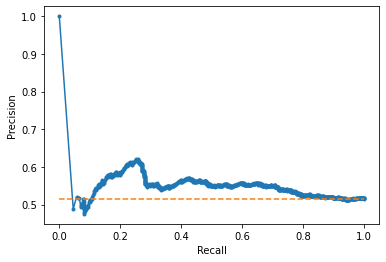

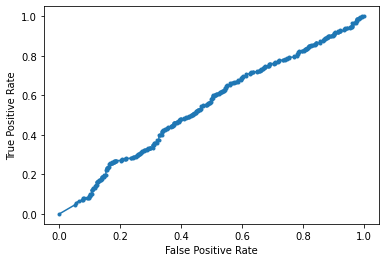

Accuracy: 53.03% Precision: 54.89% Recall: 50.11%
F1: 52.39% MCC: 0.0627
AUPRC: 55.58% AUROC: 54.55%
 accuracy [53.033707865168545]
 precision [54.8926014319809]
 recall [50.108932461873636]
 F1 [52.39179954441913]
 MCC [0.0626502949644403]
 AUPRC [55.58044483293598]
 AUROC [54.554185685617384]
2023-03-21 15:55:30.795687

Training # 1 5
2023-03-21 15:55:30.798505
2023-03-21 15:55:30.798566
Discriminator ZERO -1
Train 1:0 1801:1692 51.56%
Computed class weights: {0: 1.032210401891253, 1: 0.9697390338700722}
Valid 1:0 457:419 52.17%
FIT
2023-03-21 15:55:32.055794


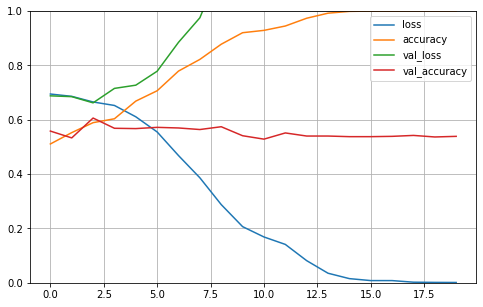


2023-03-21 15:56:55.485817

Testing # 1 5
2023-03-21 15:56:55.485915
2023-03-21 15:56:55.485956
PREDICT
2023-03-21 15:56:55.720383
Test 1:0 457:419 52.17%
Predict 1:0 457:419 52.17%
Test sizes (876, 4997) (876,)
Range of scores: 1.2050348e-22 to 1.0
Score threshold 0.5
Confusion matrix
 [[217 202]
 [202 255]]
Normalized matrix
 [[0.24771689 0.23059361]
 [0.23059361 0.29109589]]


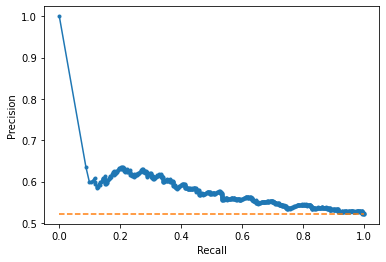

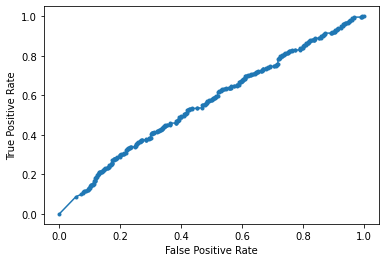

Accuracy: 53.88% Precision: 55.80% Recall: 55.80%
F1: 55.80% MCC: 0.0759
AUPRC: 59.29% AUROC: 56.34%
 accuracy [53.88127853881278]
 precision [55.798687089715536]
 recall [55.798687089715536]
 F1 [55.798687089715536]
 MCC [0.07588663223367087]
 AUPRC [59.286299957700805]
 AUROC [56.3428607239285]
2023-03-21 15:56:56.559429

Training # 2 1
2023-03-21 15:56:56.559571
2023-03-21 15:56:56.559614
Discriminator ZERO -1
Train 1:0 1786:1696 51.29%
Computed class weights: {0: 1.0265330188679245, 1: 0.9748040313549832}
Valid 1:0 472:415 53.21%
FIT
2023-03-21 15:56:57.799539


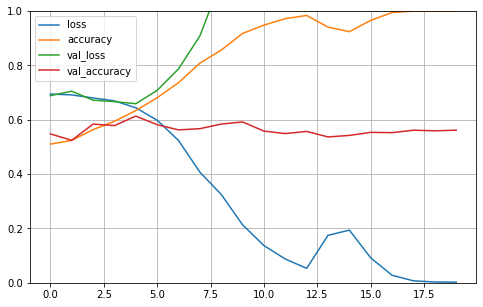


2023-03-21 15:57:56.098796

Testing # 2 1
2023-03-21 15:57:56.098891
2023-03-21 15:57:56.098926
PREDICT
2023-03-21 15:57:56.343261
Test 1:0 472:415 53.21%
Predict 1:0 463:424 52.20%
Test sizes (887, 4997) (887,)
Range of scores: 1.1361184e-21 to 1.0
Score threshold 0.5
Confusion matrix
 [[225 190]
 [199 273]]
Normalized matrix
 [[0.25366404 0.21420519]
 [0.22435175 0.30777903]]


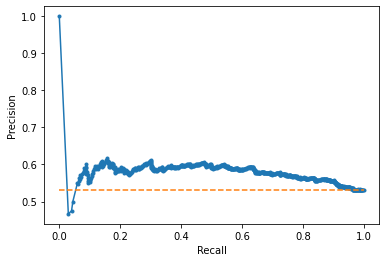

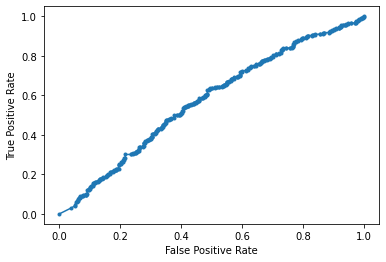

Accuracy: 56.14% Precision: 58.96% Recall: 57.84%
F1: 58.40% MCC: 0.1204
AUPRC: 58.13% AUROC: 57.27%
 accuracy [56.14430665163472]
 precision [58.963282937365015]
 recall [57.83898305084746]
 F1 [58.39572192513369]
 MCC [0.12042578291302888]
 AUPRC [58.127630585285274]
 AUROC [57.267204410863805]
2023-03-21 15:57:57.161158

Training # 2 2
2023-03-21 15:57:57.161293
2023-03-21 15:57:57.161349
Discriminator ZERO -1
Train 1:0 1806:1695 51.59%
Computed class weights: {0: 1.0327433628318583, 1: 0.9692691029900332}
Valid 1:0 452:416 52.07%
FIT
2023-03-21 15:57:58.420468


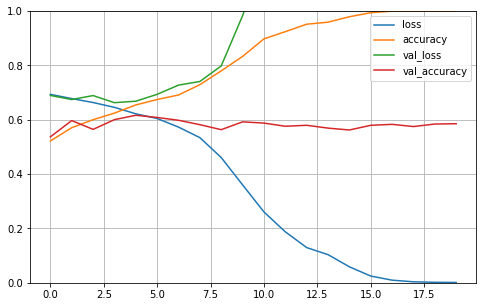


2023-03-21 15:59:22.436980

Testing # 2 2
2023-03-21 15:59:22.437073
2023-03-21 15:59:22.437109
PREDICT
2023-03-21 15:59:22.664887
Test 1:0 452:416 52.07%
Predict 1:0 440:428 50.69%
Test sizes (868, 4997) (868,)
Range of scores: 1.4301658e-18 to 1.0
Score threshold 0.5
Confusion matrix
 [[242 174]
 [186 266]]
Normalized matrix
 [[0.27880184 0.20046083]
 [0.21428571 0.30645161]]


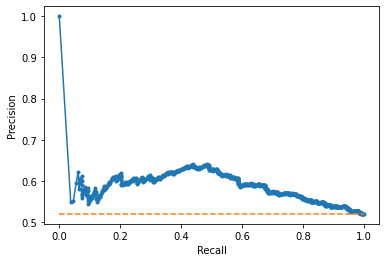

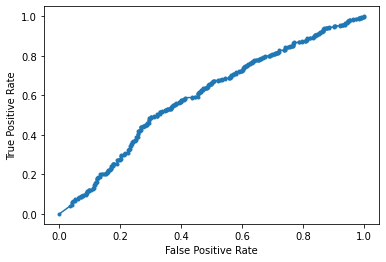

Accuracy: 58.53% Precision: 60.45% Recall: 58.85%
F1: 59.64% MCC: 0.1701
AUPRC: 59.33% AUROC: 59.76%
 accuracy [58.525345622119815]
 precision [60.45454545454545]
 recall [58.849557522123895]
 F1 [59.64125560538116]
 MCC [0.17009613006891608]
 AUPRC [59.333025204640535]
 AUROC [59.756318073519395]
2023-03-21 15:59:23.465531

Training # 2 3
2023-03-21 15:59:23.465663
2023-03-21 15:59:23.465705
Discriminator ZERO -1
Train 1:0 1805:1704 51.44%
Computed class weights: {0: 1.0296361502347418, 1: 0.97202216066482}
Valid 1:0 453:407 52.67%
FIT
2023-03-21 15:59:24.726301


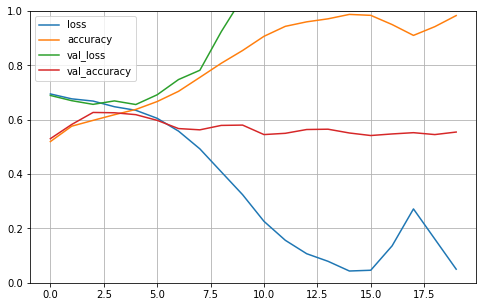


2023-03-21 16:00:48.247621

Testing # 2 3
2023-03-21 16:00:48.249066
2023-03-21 16:00:48.249408
PREDICT
2023-03-21 16:00:48.672914
Test 1:0 453:407 52.67%
Predict 1:0 500:360 58.14%
Test sizes (860, 4997) (860,)
Range of scores: 2.908393e-14 to 1.0
Score threshold 0.5
Confusion matrix
 [[192 215]
 [168 285]]
Normalized matrix
 [[0.22325581 0.25      ]
 [0.19534884 0.33139535]]


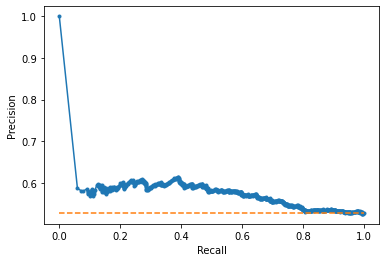

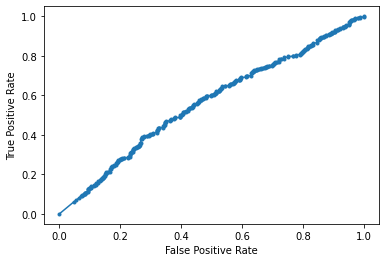

Accuracy: 55.47% Precision: 57.00% Recall: 62.91%
F1: 59.81% MCC: 0.1021
AUPRC: 58.44% AUROC: 56.07%
 accuracy [55.46511627906977]
 precision [56.99999999999999]
 recall [62.913907284768214]
 F1 [59.81112277019937]
 MCC [0.10210109177275839]
 AUPRC [58.44244533410357]
 AUROC [56.06765706103454]
2023-03-21 16:00:49.733961

Training # 2 4
2023-03-21 16:00:49.735620
2023-03-21 16:00:49.735972
Discriminator ZERO -1
Train 1:0 1826:1664 52.32%
Computed class weights: {0: 1.0486778846153846, 1: 0.9556407447973713}
Valid 1:0 432:447 49.15%
FIT
2023-03-21 16:00:52.017736


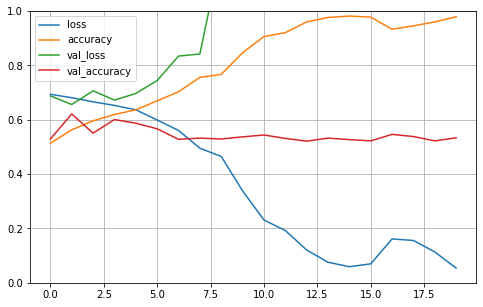


2023-03-21 16:01:50.743732

Testing # 2 4
2023-03-21 16:01:50.743837
2023-03-21 16:01:50.743875
PREDICT
2023-03-21 16:01:50.972263
Test 1:0 432:447 49.15%
Predict 1:0 492:387 55.97%
Test sizes (879, 4997) (879,)
Range of scores: 2.299969e-18 to 1.0
Score threshold 0.5
Confusion matrix
 [[212 235]
 [175 257]]
Normalized matrix
 [[0.24118316 0.26734926]
 [0.19908987 0.2923777 ]]


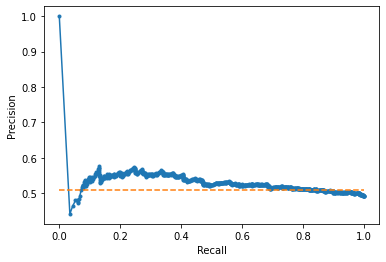

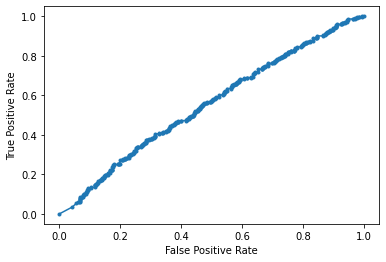

Accuracy: 53.36% Precision: 52.24% Recall: 59.49%
F1: 55.63% MCC: 0.0697
AUPRC: 53.42% AUROC: 55.41%
 accuracy [53.35608646188851]
 precision [52.235772357723576]
 recall [59.49074074074075]
 F1 [55.62770562770562]
 MCC [0.06966911294909547]
 AUPRC [53.420500239088376]
 AUROC [55.40822561935538]
2023-03-21 16:01:51.829487

Training # 2 5
2023-03-21 16:01:51.830619
2023-03-21 16:01:51.830669
Discriminator ZERO -1
Train 1:0 1809:1685 51.77%
Computed class weights: {0: 1.0367952522255193, 1: 0.9657269209508016}
Valid 1:0 449:426 51.31%
FIT
2023-03-21 16:01:53.070293


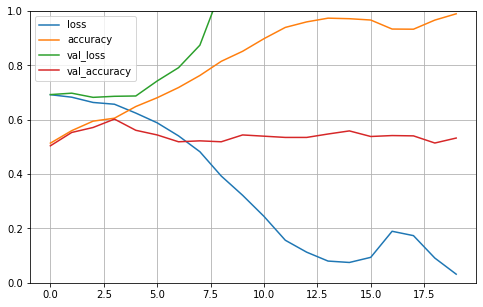


2023-03-21 16:03:16.524041

Testing # 2 5
2023-03-21 16:03:16.524471
2023-03-21 16:03:16.524506
PREDICT
2023-03-21 16:03:16.766672
Test 1:0 449:426 51.31%
Predict 1:0 410:465 46.86%
Test sizes (875, 4997) (875,)
Range of scores: 3.503389e-15 to 1.0
Score threshold 0.5
Confusion matrix
 [[241 185]
 [224 225]]
Normalized matrix
 [[0.27542857 0.21142857]
 [0.256      0.25714286]]


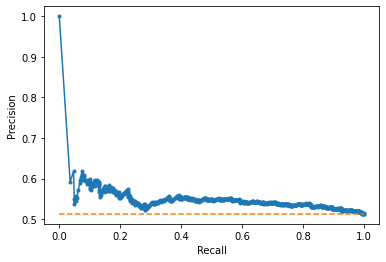

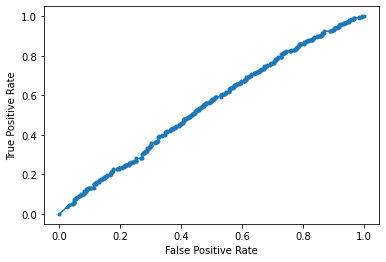

Accuracy: 53.26% Precision: 54.88% Recall: 50.11%
F1: 52.39% MCC: 0.0670
AUPRC: 55.59% AUROC: 54.84%
 accuracy [53.25714285714286]
 precision [54.87804878048781]
 recall [50.11135857461024]
 F1 [52.386495925494756]
 MCC [0.06695058212753024]
 AUPRC [55.59289328787991]
 AUROC [54.83886989345128]
2023-03-21 16:03:17.615891


In [34]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_sequence(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_sequence(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [35]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 54.27% std 1.98
 precision mean 55.71% std 2.46
 recall mean 56.20% std 4.37
 F1 mean 55.88% std 2.83
 MCC mean 0.08% std 0.04
 AUPRC mean 57.12% std 1.87
 AUROC mean 55.96% std 1.91
 accuracy [[52.643678160919535], [54.52488687782805], [51.82567726737338], [53.033707865168545], [53.88127853881278], [56.14430665163472], [58.525345622119815], [55.46511627906977], [53.35608646188851], [53.25714285714286]]
 precision [[54.713114754098356], [54.27350427350427], [53.93794749403341], [54.8926014319809], [55.798687089715536], [58.963282937365015], [60.45454545454545], [56.99999999999999], [52.235772357723576], [54.87804878048781]]
 recall [[58.29694323144105], [57.466063348416284], [51.13122171945701], [50.108932461873636], [55.798687089715536], [57.83898305084746], [58.849557522123895], [62.913907284768214], [59.49074074074075], [50.11135857461024]]
 F1 [[56.448202959830866], [55.82417582417582], [52.49709639953542], [52.39179954441913], [55.798687089715536], [58.3957219251336